# Rag with chunk distilation search

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from stringdale.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from pathlib import Path
from pprint import pprint

from stringdale.diagrams import (
    Define,Scope,
    V,E,
    draw_diagram
)
from stringdale.chat import Chat
from stringdale.std import Condition as C,StructureJson
from stringdale.db import ChromaClient



In [ ]:
chroma_client = ChromaClient()

## Upload docs

In [ ]:
sample_doc = {'text':"""
The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.

The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.

The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.
""",
'id':'animal_book'
}

In [ ]:
def splitter(doc):
    doc_id = doc['id']
    text = doc['text']
    return [{'text':chunk.strip(),'id':f'{doc_id}_{i}'} for i,chunk in enumerate(text.split('\n\n'))]

chunks = splitter(sample_doc)
chunks



[{'text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.',
  'id': 'animal_book_0'},
 {'text': 'The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across the Arctic ice in search of food, often following polar bears to scavenge their leftovers.',
  'id': 'animal_book_1'},
 {'text': "The octopu

In [ ]:
unstructured_summary = {
   'doc':{
      'text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan.",
      'id': 'animal_book_2'
   },
   'description': 'Description of elephants as intelligent and social animals.',
}

StructureJson('text=description','id=doc.id','metadata.full_text=doc.text')(**unstructured_summary)

{'text': 'Description of elephants as intelligent and social animals.',
 'id': 'animal_book_2',
 'metadata': {'full_text': "The octopus stands out as one of the ocean's most intelligent invertebrates. With nine brains (one central brain and eight additional ones in each arm), these cephalopods can solve complex puzzles, open jars, and even use tools. Their remarkable ability to change both color and texture allows them to perfectly mimic their surroundings, making them masters of disguise. Despite their impressive capabilities, most octopus species live only 1-2 years, making their intelligence even more remarkable given their short lifespan."}}

In [ ]:
topic_summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that summarizes chunks of text.
        Here are some examples of how to summarize text:
        Text:
        Dogs are loyal companions that come in many breeds. They are known for their intelligence, 
        trainability and ability to form strong bonds with humans. Dogs have been domesticated 
        for thousands of years and serve many roles including pets, working animals, and service animals.
        They communicate through barking, body language and facial expressions. Most dogs are social 
        animals that thrive on interaction with their human families.
        Summary:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'{{text}}'}
    ])

res = await topic_summarizer(text=chunks[0]['text'])
res


{'role': 'assistant',
 'content': 'Description of elephants as intelligent and social animals with strong family bonds.',
 'meta': {'input_tokens': 292, 'output_tokens': 21}}

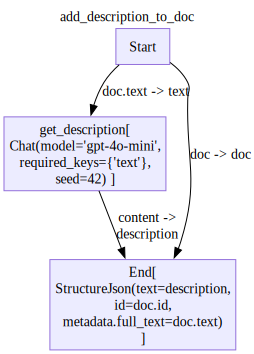

In [ ]:
with Define('add_description_to_doc',type='flow') as AddDesc:
    V('get_description',topic_summarizer,inputs=['Start(text=doc.text)'])
    V('End',StructureJson('text=description','id=doc.id','metadata.full_text=doc.text'),
        inputs=['Start(doc=doc)',
        'get_description(description=content)'
        ])

In [ ]:
add_desc = AddDesc()
for trace in add_desc.run({'doc':sample_doc}):
    # trace.pprint()
    pass
add_desc.output


{'text': 'Description of elephants, arctic foxes, and octopuses, highlighting their intelligence, adaptability, and unique features.',
 'id': 'animal_book',
 'metadata': {'full_text': "\nThe elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.\n\nThe arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. During winter, its thick white fur provides both insulation and camouflage in the snowy landscape, while in summer its coat turns brownish-gray to blend with the tundra. These resourceful predators can survive temperatures as low as -50°C (-58°F) and will travel vast distances across 

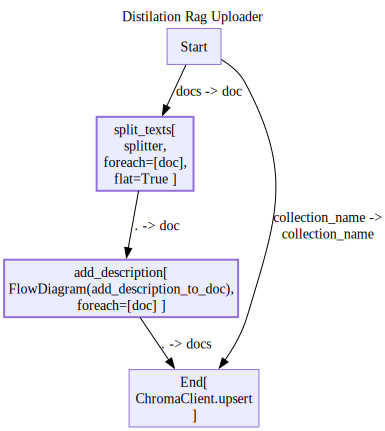

In [ ]:
# TODO consider adding zip to stringdale foreach syntax
with Define('Distilation Rag Uploader',type='flow') as DistRagUpload:
    V('split_texts',splitter,inputs=['Start(doc=docs)'],for_each=['doc'],flat=True)
    V('add_description',AddDesc,
        inputs=['split_texts(doc=.)'],
        for_each=['doc'])
    V('End',chroma_client.upsert,inputs=['add_description(docs)','Start(collection_name=collection_name)'])


In [ ]:
chroma_client.add_collection("animal_book",exists_ok=True)
d = DistRagUpload()
for trace in d.run({'docs':[sample_doc],'collection_name':'animal_book'}):
    # trace.pprint()
    pass

d.output


[{'text': 'Description of elephants as intelligent and social animals with strong family bonds.',
  'id': 'animal_book_0',
  'metadata': {'full_text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.'}},
 {'text': 'The arctic fox is a well-adapted animal for extreme cold, with thick white fur for insulation and camouflage in winter, turning brownish-gray in summer. It survives temperatures as low as -50°C and scavenges from polar bears across the Arctic ice.',
  'id': 'animal_book_1',
  'metadata': {'full_text': 'The arctic fox is a fascinating animal that has adapted perfectly to life in the extreme cold. Duri

In [ ]:
chroma_client.list('animal_book')

[{'id': 'animal_book_0',
  'text': 'Description of elephants as intelligent and social animals with strong family bonds.',
  'metadata': {'full_text': 'The elephant is one of the most remarkable creatures on Earth. Known for their intelligence and complex social structures, elephants form deep family bonds that can last a lifetime. These gentle giants possess remarkable memory capabilities and demonstrate emotional behaviors like mourning their dead. Their distinctive trunks, containing over 40,000 muscles, serve multiple purposes from gathering food to expressing affection.'},
  'embedding': array([ 0.06449884,  0.02342647, -0.02490086, ...,  0.00664062,
         -0.00696826,  0.02305202])},
 {'id': 'animal_book_1',
  'text': 'The arctic fox is a well-adapted animal for extreme cold, with thick white fur for insulation and camouflage in winter, turning brownish-gray in summer. It survives temperatures as low as -50°C and scavenges from polar bears across the Arctic ice.',
  'metadata'

## Query docs


In [ ]:
distilled_query = topic_summarizer = Chat(model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that predicts what kind of summaries will be helpful for a given query.
        Here are some examples:
        query:
        I have an elephant and a dog. What is the most important thing about them?
        Summaries:
        Descriptions of elephants.
        Descriptions of dogs.
        query:
        What is the most important thing about elephants?
        Summaries:
        Descriptions of elephants.
        query:
        What is the most important thing about dogs?
        Summaries:
        Description of dogs as pets.
        '''},
        {'role':'user','content':'query:{{query}}'},
        {'role':'assistant','content':'summaries:'}

    ])

res = await distilled_query(query="I need help with my lion choco")
pprint(res)

{'content': 'Descriptions of lion chocolates.',
 'meta': {'input_tokens': 220, 'output_tokens': 13},
 'role': 'assistant'}


In [ ]:
full_text_rag_prompt = [
            {'role':'system','content':'''
            You are a helpful assistant that answers questions about animals.

            Here are some examples of how to answer questions about animals:
            {% for example in examples %}
            Question: {{example['question']}}
            Answer: {{example['answer']}}
            {% endfor %}

            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['metadata']['full_text']}}
            {% endfor %}
            '''},
            {'role':'user','content':'{{input}}'},
            ]

style_examples = [
    {
        'question': "What are the key traits of Pandas?",
        'answer': """Here are the key traits of Pandas:
            • Pandas are a type of bear
            • They are native to South America
            • They are known for their black and white fur
            • They are known for their love of bamboo"""
    },
    {
        'question': "What are the key traits of Lions?",
        'answer': """Here are the key traits of Lions:
            • Lions are a type of bear
            • They are native to Africa
            • They are known for their mane of hair"""
    }
]
full_text_rag_chat = Chat(model='gpt-4o-mini',messages=full_text_rag_prompt,examples=style_examples)

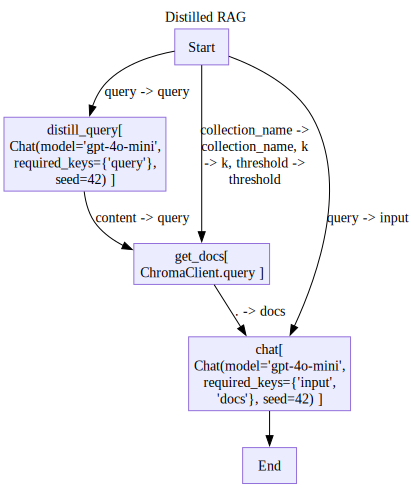

In [ ]:
with Define('Distilled RAG',type='flow') as DistRag:
    V('distill_query',distilled_query,
        inputs=['Start(query=query)'],
    )
    V('get_docs',chroma_client.query,
        inputs=['distill_query(query=content)','Start(collection_name=collection_name,k=k,threshold=threshold)'],
    )
    V('chat',full_text_rag_chat,
        inputs=['get_docs(docs)','Start(input=query)'],
        outputs=['End']
    )
    

In [ ]:
d=DistRag()
for trace in d.run({'query':'I need help with my elephant choco','collection_name':'animal_book','k':2,'threshold':1}):
    trace.pprint()
    pass
pprint(d.output)

Node Start:
{ 'input': { 'collection_name': 'animal_book',
             'k': 2,
             'query': 'I need help with my elephant choco',
             'threshold': 1},
  'output': { 'collection_name': 'animal_book',
              'k': 2,
              'query': 'I need help with my elephant choco',
              'threshold': 1}}
Node distill_query:
{ 'input': {'query': 'I need help with my elephant choco'},
  'output': { 'content': 'Descriptions of elephants and care tips for pet '
                         'elephants.',
              'meta': {'input_tokens': 220, 'output_tokens': 18},
              'role': 'assistant'}}
Node get_docs:
{ 'input': { 'collection_name': 'animal_book',
             'k': 2,
             'query': 'Descriptions of elephants and care tips for pet '
                      'elephants.',
             'threshold': 1},
  'output': [ { 'distance': 0.758659303188324,
                'id': 'animal_book_0',
                'metadata': { 'full_text': 'The elephant is one